In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [19]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [26]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [21]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27,2),generator=g)


In [37]:
emb = C[X]
# emb[:3],C[:6],X[:3]

emb.shape

torch.Size([32, 3, 2])

In [40]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [46]:
# h = emb.view((32,6)) @ W1 + b1
h = emb.view((-1,6)) @ W1 + b1 #pytorch will substitute -1 with whatever correct number acc to 6, as emb size may differ
h = torch.tanh(h)

In [44]:
h.shape

torch.Size([32, 100])

In [47]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [50]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [55]:
# counts = logits.exp()
# prob = counts/counts.sum(1,keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits,Y)
loss

tensor(17.5300)

In [56]:
##### writing above in organised way

In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
#   print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
#     print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape,Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)

W1 = torch.randn((block_size*2,100),generator=g)
b1 = torch.randn(100, generator=g)

W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]


In [7]:
for p in parameters:
      p.requires_grad = True

In [117]:
# will train on whole data => slow 

for _ in range(10):
      #forward pass
      emb = C[X] # 32,3,2
      h = torch.tanh(emb.view(-1,6) @ W1 +b1) #32,100
      logits = h @ W2 +b2
      loss = F.cross_entropy(logits,Y)
      print(loss.item())
      
      #backward pass
      for p in parameters:
            p.grad = None
      loss.backward()
      
      #update
      for p in parameters:
            p.data += -0.2 * p.grad

2.524750232696533
2.471827983856201
2.4583544731140137
2.4513683319091797
2.4467172622680664
2.4432458877563477
2.4404942989349365
2.4382309913635254
2.436323881149292
2.4346888065338135


In [108]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

In [125]:
# will train on randomly selected minibatches data => slow 


for i in range(1000):
      
      #minibatch construct
      ix = torch.randint(0, X.shape[0], (32,))
      
      #forward pass
      emb = C[X[ix]] # 32,3,2
      h = torch.tanh(emb.view(-1,6) @ W1 +b1) #32,100
      logits = h @ W2 +b2
      loss = F.cross_entropy(logits,Y[ix])
      print(loss.item())
      #backward pass
      for p in parameters:
            p.grad = None
      loss.backward()
      
      #update
      # lr = lrs[i]
      lr = 0.15
      for p in parameters:
            p.data += -lr * p.grad
            
      # lossi.append(loss.item())
      # lri.append(lr)

2.329906702041626
2.195978879928589
2.3128914833068848
2.590156316757202
2.187030792236328
2.6276068687438965
2.7368674278259277
2.2718698978424072
2.4786932468414307
2.766965389251709
2.5512537956237793
2.7775230407714844
2.086087226867676
2.4556267261505127
2.612051010131836
2.45363187789917
2.541989326477051
2.4604737758636475
2.395055055618286
2.2280447483062744
2.6304664611816406
2.4505624771118164
2.3236005306243896
2.442521095275879
2.5671422481536865
2.3927271366119385
2.0881216526031494
2.540757179260254
2.657890796661377
2.2242934703826904
2.4659831523895264
2.2171971797943115
2.4669506549835205
2.5519495010375977
2.7056121826171875
2.151197910308838
2.529775619506836
2.330178737640381
2.650404214859009
2.3350846767425537
2.66495418548584
2.5716075897216797
2.609555244445801
1.9454035758972168
2.680563449859619
2.40366268157959
2.7475504875183105
2.5511248111724854
2.5872690677642822
2.2519752979278564
2.6434710025787354
2.5629260540008545
3.121847629547119
2.4641997814178467

In [112]:
# plt.plot(lri,lossi)



In [126]:
emb = C[X] # 32,3,2
h = torch.tanh(emb.view(-1,6) @ W1 +b1) #32,100
logits = h @ W2 +b2
loss = F.cross_entropy(logits,Y)
print(loss.item())

2.5157668590545654


In [ ]:
#training split, dev/validation split, test split => 80%, 10%, 10%



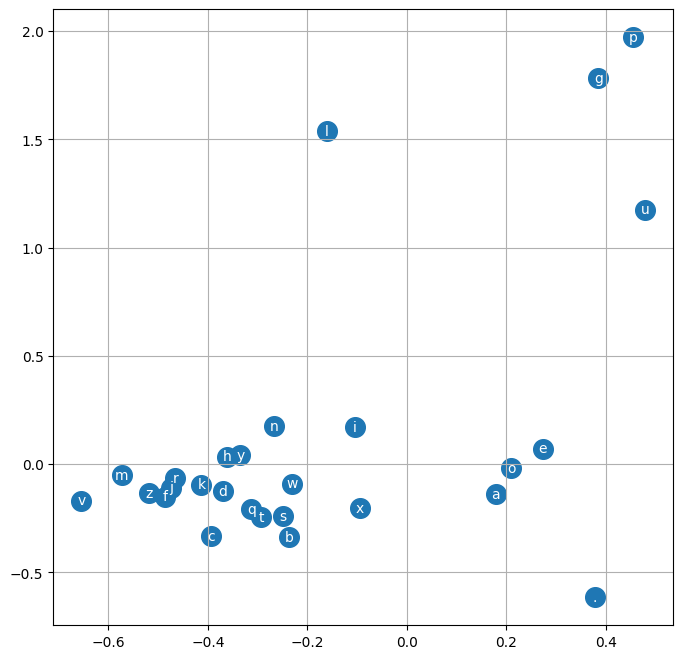

In [127]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [128]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

bria.
amyanleelevn.
hahalerenman.
badrari.
azered.
elinnnmionen.
adennesnanar.
katzioh.
karin.
sadbergehianes.
kin.
renlynnnn.
pocanus.
bavdar.
yahlemehs.
kay.
avannyan.
hia.
aalynnsus.
zakaleen.


In [14]:
print(torch.cuda.is_available())

False
